In [1]:
import bs4; print( 'bs4 ' + bs4.__version__)
from bs4 import BeautifulSoup, SoupStrainer

import sklearn; print( 'sklearn ' + sklearn.__version__)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

import nltk; print( 'nltk ' + nltk.__version__)
from nltk import word_tokenize, pos_tag, RegexpParser;
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, LancasterStemmer

# from autocorrect import spell; print('autocorrect 0.3.0')

import re; print('re ' + re.__version__)
import requests; print('requests ' + requests.__version__)

import pandas as pd; print('pandas ' + pd.__version__)
import seaborn as sns; print('seaborn ' + sns.__version__)
import numpy as np; print('numpy ' + np.__version__)

import pyLDAvis; print('pyLDAvis ', pyLDAvis.__version__)
import pyLDAvis.sklearn

import matplotlib; print('matplotlib', matplotlib.__version__)
import matplotlib.pyplot as plt;

bs4 4.6.3
sklearn 0.19.1
nltk 3.3
re 2.2.1
requests 2.19.1
pandas 0.22.0
seaborn 0.8.1
numpy 1.14.2
pyLDAvis  2.1.2
matplotlib 2.2.2


# Final Project - Topic Modeling

First we continue where we left off with [Homework 5](https://github.com/kjprice/smu-nlp/blob/e769b93945e6f45ae90aab3ec53b6595ae7bc7da/homework/Homework%205.ipynb).

### Code from Homework 5


In [2]:
# The home page for various movies' reviews, from which will get the links for individual reviews
review_home_urls = {
    'green_mile': 'https://www.imdb.com/title/tt0120689/reviews?ref_=tt_ql_3',
    'forest_gump': 'https://www.imdb.com/title/tt0109830/reviews?ref_=tt_ov_rt',
    'cast_away': 'https://www.imdb.com/title/tt0162222/reviews?ref_=tt_ov_rt',
    'terminal': 'https://www.imdb.com/title/tt0362227/reviews?ref_=tt_ql_3',
    'catch_me_if_you_can': 'https://www.imdb.com/title/tt0264464/reviews?ref_=tt_ql_3',
    'road_to_perdition': 'https://www.imdb.com/title/tt0257044/reviews?ref_=tt_ql_3',
}
def get_text_from_url(url):
    return requests.get(url).text
text = get_text_from_url(review_home_urls['green_mile'])


In [3]:
def get_all_links_from_html(html):
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a', href=True))
    urls = [str(tag.attrs['href']) for tag in tags]
    return urls
all_links = get_all_links_from_html(text)

In [4]:
def get_review_urls_from_links(links):
    url_template = 'https://www.imdb.com{}'
    # url_template = 'http://www.gutenberg.org/files/{}/{}-h/{}-h.htm'
    return [url_template.format(link) for link in links]

urls = get_review_urls_from_links(all_links)

In [5]:
def relevent_link(link):
    if '/review/' in link:
        return True
    return False

In [6]:
def get_relevent_links(links):
    relevent_links = filter(relevent_link, links)
    unique_relevent_links = set(relevent_links)
    return list(unique_relevent_links)
relevent_urls = get_relevent_links(urls)
len(relevent_urls)

25

In [7]:
def strain_content(name, attrs):
    if name == 'div' and dict(attrs).get('class', None) == 'content':
        return True
    return False
def clean_review_text(text):
    return re.split('\\n\\n\s+\d+ out of \d+', text)[0]
def get_review_from_url(url):
    html = get_text_from_url(url)
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer(strain_content))
    review = clean_review_text(tags.text)
    return review

<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-7-fe7ee7139024>:6: DeprecationWarning: invalid escape sequence \s
  return re.split('\\n\\n\s+\d+ out of \d+', text)[0]


In [8]:
def get_review_from_site(url):
    reviews = []

    reviews_home_text = get_text_from_url(url)
    all_links = get_all_links_from_html(reviews_home_text)
    relevent_links = get_relevent_links(all_links)

    review_urls = get_review_urls_from_links(relevent_links)
    for url in review_urls:
        reviews.append(get_review_from_url(url))
        # break
    return reviews

In [9]:
review_home_urls.values()

dict_values(['https://www.imdb.com/title/tt0120689/reviews?ref_=tt_ql_3', 'https://www.imdb.com/title/tt0109830/reviews?ref_=tt_ov_rt', 'https://www.imdb.com/title/tt0162222/reviews?ref_=tt_ov_rt', 'https://www.imdb.com/title/tt0362227/reviews?ref_=tt_ql_3', 'https://www.imdb.com/title/tt0264464/reviews?ref_=tt_ql_3', 'https://www.imdb.com/title/tt0257044/reviews?ref_=tt_ql_3'])

In [10]:
def get_reviews_from_all_sites():
    all_reviews = []
    review_titles = review_home_urls.keys()
    for title in review_titles:
        review_home_url = review_home_urls[title]
        all_reviews = all_reviews + get_review_from_site(review_home_url)
    return all_reviews

## Retrieve All Reviews

In [11]:
all_reviews = get_reviews_from_all_sites()

In [12]:
len(all_reviews)

150

In [13]:
all_reviews[0][0:100]

'\nTHE GREEN MILE (1999) ****Starring: Tom Hanks, David Morse, Michael Clarke Duncan, Bonnie Hunt, Jam'

## Preprocess Data

In [14]:
def sentences_to_words(sentences):
    return [word_tokenize(sentence) for sentence in sentences]
# sentences_to_words([all_reviews[0]])[0][0:5]

In [15]:
custom_stop_words = ['the', 'green', 'mile', 'shawshank', 'redemption', 'one']
stop_words = custom_stop_words + stopwords.words('english')
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]
remove_stop_words(['he', 'her', 'boss', '.', 'the'])

['boss', '.']

In [16]:
def include_only_numbers_and_letters(words):
    regex_matcher = '^[a-zA-Z0-9]+$'
    return [word for word in words if re.match(regex_matcher, word)]
# include_only_numbers_and_letters(['1', 'KJ', '.'])

In [17]:
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer('english')
stemmer = LancasterStemmer()
def lemmatize_word(word):
    lemma_word = stemmer.stem(word)
    if wordnet.synsets(lemma_word):
        return lemma_word
    else:
        return word
def lemmatize_words(words):
    return [lemmatize_word(word) for word in words]
lemmatize_words(['running', 'fastest', 'hats', 'movie'])

['run', 'fastest', 'hat', 'movie']

In [18]:
def preprocess_documents(documents):
    documents_with_formatted_words = [document.lower().strip() for document in documents]
    documents_of_words = sentences_to_words(documents_with_formatted_words)
    content_words_and_characters = [remove_stop_words(words) for words in documents_of_words]
    content_words = [include_only_numbers_and_letters(characters) for characters in content_words_and_characters]
    lematized_words = [lemmatize_words(words) for words in content_words]
    return lematized_words  
preprocess_documents(all_reviews[0:2])[0][0:5]

['1999', 'tom', 'hank', 'david', 'mors']

In [19]:
documents_of_words = preprocess_documents(all_reviews)
documents_of_words[0][0:7]

['1999', 'tom', 'hank', 'david', 'mors', 'michael', 'clark']

### Take a look at words

In [20]:
list_of_all_words = [word for document in documents_of_words for word in document]
len(list_of_all_words)

21896

In [21]:
# Unique Words
len(set(list_of_all_words))

4154

### Flatten documents back to sentences

In [22]:
flattened_documents = [' '.join(document) for document in documents_of_words]

## Perform Topic Modeling

Inspired, in part by https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [23]:
# Settings
NUMBER_OF_FEATURES = 1000
NUMBER_OF_TOPICS  = 10
NUMBER_OF_TOP_WORDS = 10

In [24]:
def topics_to_map(model, feature_names, no_top_words):
    map = []
    for topic_idx, topic in enumerate(model.components_):
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        map.append(stuff)
    return map


In [25]:
# Helper function 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}:".format(topic_idx), end=' ')
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print (stuff)

### Vectorize (Bag Of Words)

In [26]:
tf_vectorizer = TfidfVectorizer(max_features=NUMBER_OF_FEATURES)
tf = tf_vectorizer.fit_transform(flattened_documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [27]:
flattened_documents[0][0:100]

'1999 tom hank david mors michael clark duncan bonny hunt jam cromwell michael jet doug hutchison gar'

### NMF

In [28]:
nmf = NMF(n_components=NUMBER_OF_TOPICS, random_state=1, alpha=.1, l1_ratio=.7, init='nndsvd').fit(tf)

In [29]:
nmf_topic_map = topics_to_map(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)
display_topics(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)

Topic 0: film movie real hank act story watch ev like think
Topic 1: chuck island noland kelly away wilson zemeckis crash plan fedex
Topic 2: son sullivan michael rooney newman perdition road con father law
Topic 3: frank abagnale dicaprio spielberg walk catch fbi con hanratty christopher
Topic 4: forrest gump jenny school vietnam meet wright life beat history
Topic 5: spielberg airport terminal viktor steven hank catherine stuck new country
Topic 6: frank pretend funny lawyer carl doctor tells watch movie pilot
Topic 7: prison duncan edgecomb guard michael coffey paul clark darabont men
Topic 8: best academy award nominated star second sin dram hank win
Topic 9: gave movie whole vulnerable weak till long hop giant depth


### LDA

In [30]:
lda = LatentDirichletAllocation(n_topics=NUMBER_OF_TOPICS, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)



/usr/local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [31]:
display_topics(lda, tf_feature_names, NUMBER_OF_TOP_WORDS)


Topic 0: film act comp reason quit character best movie academy thing
Topic 1: review read sens sit complex direct chuck like seriously good
Topic 2: son hank road father commit newman paul movie perdition eye
Topic 3: film movie hank son act story newman real perdition tom
Topic 4: rooney son sullivan michael con movie hank maguire hoechlin perdition
Topic 5: film think zemeckis movie wright perform stuff mike act take
Topic 6: rooney movie car real grow behind story choose relationship ar
Topic 7: crusoe truly life perdition amazing truth superb struggles hank moving
Topic 8: level spirit bas incredibly villain nasser mors two tells rub
Topic 9: tom movie mean beauty forrest movies mess believe like seen


In [32]:
topic_map = nmf.transform(tf)
# topic_map = lda.transform(tf)

# Visualizations

### Word counts per document

In [33]:
number_of_words = [len(review.split(' ')) for review in all_reviews]

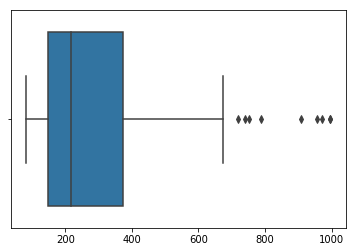

In [34]:
sns.boxplot(number_of_words)

In [35]:
np.median(number_of_words)

216.5

### Scatterplot

With help from https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

In [36]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

In [37]:
tsne_lda = tsne_model.fit_transform(topic_map)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.066991
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.741772
[t-SNE] Error after 900 iterations: 0.144180


In [38]:
categories = review_home_urls.keys()

In [39]:
categories_vector = []
for category in categories:
    for i in range(int(len(all_reviews) / len(categories))):
        categories_vector.append(category)

In [40]:
primary_topics = [np.argmax(transformed_topics) for transformed_topics in lda.transform(tf)]
primary_topics_text = [nmf_topic_map[topic_index] for topic_index in primary_topics]

In [41]:
category_df = pd.DataFrame({
    'x': tsne_lda[:, 0],
    'y': tsne_lda[:, 1],
    'group': categories_vector,
    'primary_topic': primary_topics,
    'primary_topics_text': primary_topics_text,
    'text': flattened_documents
})

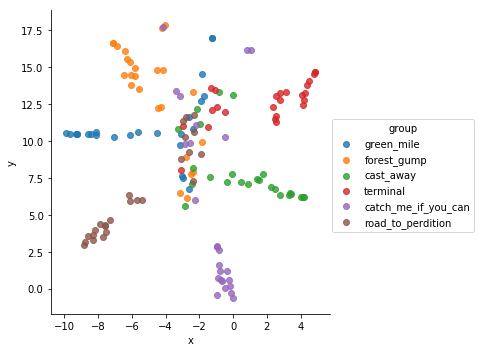

In [49]:
sns.lmplot(x='x', y='y', fit_reg=False, data=category_df, hue='group')

### pyLDAvis

In [43]:
# Help by https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(nmf, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      50.945541        1       1   90.725800  339.445526
2       8.266541        1       2   82.024315  -64.181938
1       7.806677        1       3  260.534180  123.178139
5       7.763975        1       4   40.446354 -276.688477
3       7.492530        1       5 -323.752167   45.284588
4       6.629232        1       6 -168.178848  247.179092
7       6.166016        1       7   32.469536  137.529114
6       1.823586        1       8 -117.400612   -6.278965
9       1.578081        1       9  284.168854 -130.463272
8       1.527822        1      10 -195.382278 -208.324600, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
349   Default  16.000000      forrest  16.000000  30.0000  30.0000
136   Default  12.000000        chuck  12.000000  29.0000  29.0000
597   Default  14.000000        movie  14.000000  28.0000  28.0000
355   Default  11.000000        frank  11.000000  27.0000  27.0000
78    Default   7.000000         best   7.000000  26.0000  26.0000
823   Default  13.000000    spielberg  13.000000  25.0000  25.0000
406   Default   9.000000         gump   9.000000  24.0000  24.0000
24    Default   7.000000      airport   7.000000  23.0000  23.0000
880   Default   7.000000     terminal   7.000000  22.0000  22.0000
478   Default   7.000000       island   7.000000  21.0000  21.0000
954   Default   6.000000        watch   6.000000  20.0000  20.0000
6     Default   7.000000     abagnale   7.000000  19.0000  19.0000
576   Default   8.000000      michael   8.000000  18.0000  18.0000
213   Default   6.000000     dicaprio   6.000000  17.0000  17.0000
411   Default  12.000000         hank  12.000000  16.0000  16.0000
853   Default   5.000000     sullivan   5.000000  15.0000  15.0000
814   Default   6.000000          son   6.000000  14.0000  14.0000
699   Default   4.000000       prison   4.000000  13.0000  13.0000
484   Default   5.000000        jenny   5.000000  12.0000  12.0000
750   Default   5.000000       rooney   5.000000  11.0000  11.0000
621   Default   4.000000       noland   4.000000  10.0000  10.0000
939   Default   4.000000       viktor   4.000000   9.0000   9.0000
762   Default   3.000000          say   3.000000   8.0000   8.0000
363   Default   3.000000        funny   3.000000   7.0000   7.0000
617   Default   4.000000       newman   4.000000   6.0000   6.0000
236   Default   4.000000       duncan   4.000000   5.0000   5.0000
890   Default   5.000000         time   5.000000   4.0000   4.0000
896   Default   6.000000          tom   6.000000   3.0000   3.0000
662   Default   4.000000    perdition   4.000000   2.0000   2.0000
14    Default   6.000000          act   6.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
689   Topic10   0.414657      portray   1.194141   3.1236  -3.7503
768   Topic10   0.133762   screenplay   0.392427   3.1050  -4.8817
945   Topic10   0.065292         vote   0.193580   3.0945  -5.5989
822   Topic10   0.164177        spent   0.494805   3.0781  -4.6768
771   Topic10   0.529687       second   1.673134   3.0312  -3.5054
99    Topic10   0.156574        bubba   0.499447   3.0214  -4.7242
184   Topic10   0.171947          dan   0.596057   2.9382  -4.6305
244   Topic10   0.129332         edit   0.474688   2.8811  -4.9153
972   Topic10   0.420082          win   1.575994   2.8591  -3.7373
796   Topic10   0.446760          sin   1.735070   2.8245  -3.6757
671   Topic10   0.291193      picture   1.161000   2.7983  -4.1037
17    Topic10   0.310958        adapt   1.251637   2.7888  -4.0381
564   Topic10   0.121512  masterpiece   0.494101   2.7786  -4.9777
203   Topic10   0.144437     delivers   0.640833   2.6914  -4.8049
369   Topic10   0.275332         gary   1.302241   2.6275  -4.1597
229   Topic10   0.433797         dram   2.226

### Heatmap

In [44]:
words = tf_vectorizer.get_feature_names()

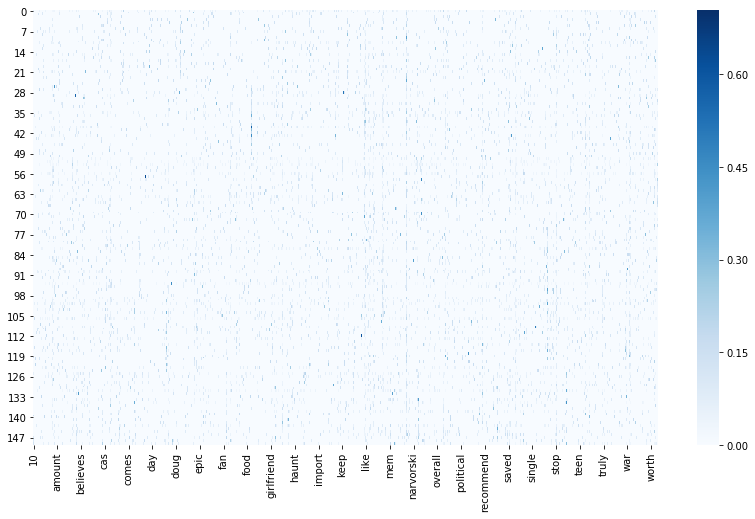

In [45]:
sns.heatmap(pd.DataFrame(tf.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8)

### Frequency of categories and topics

In [46]:
category_df[category_df['primary_topics_text'] == 'products art never us cent provide profit unfortunately expense pond']

,group,primary_topic,primary_topics_text,text,x,y


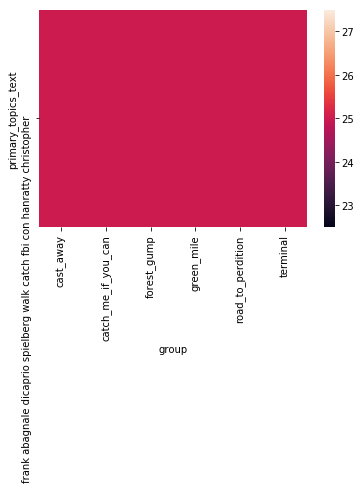

In [47]:
sns.heatmap(category_df.groupby(['primary_topics_text', 'group']).size().unstack())

In [50]:
category_df

,group,primary_topic,primary_topics_text,text,x,y
0,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,1999 tom hank david mors michael clark duncan ...,-9.326426,10.481794
1,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,poss favorite movie ev seen many movies certai...,-3.172189,9.743814
2,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,movie real gem hard find fault hank excel role...,-8.130284,10.623970
3,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,reason oscar win tour de force 67 rank film im...,-1.877655,12.694761
4,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,excel movie picture first saw trail october th...,-3.099057,10.475416
5,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,doubt see movie length 3 hour dea film surpris...,-1.263281,17.020771
6,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,every way wonderful film imo deserves rare har...,-8.578020,10.478954
7,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,world teem wretch prison wherein man men house...,-9.904798,10.522441
8,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,length movie perfect kept story amazing degree...,-2.361107,10.806163
9,green_mile,3,frank abagnale dicaprio spielberg walk catch f...,expect movie norm want see tom hank movie goes...,-2.640566,6.776878


In [48]:
category_df.groupby(['primary_topics_text', 'group']).size().unstack()

group,cast_away,catch_me_if_you_can,forest_gump,green_mile,road_to_perdition,terminal
primary_topics_text,,,,,,
frank abagnale dicaprio spielberg walk catch fbi con hanratty christopher,25,25,25,25,25,25
